In [1]:
import warnings

import numpy as np
import pandas as pd

import sklearn.model_selection as skm
import sklearn.linear_model as skl

#from statsmodels.api import OLS
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, r2_score

from matplotlib.pyplot import subplots
from ISLP import load_data

In [2]:
College = load_data('College')
College

,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
0,Yes,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
1,Yes,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
2,Yes,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
3,Yes,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
4,Yes,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
772,No,2197,1515,543,4,26,3089,2029,6797,3900,500,1200,60,60,21.0,14,4469,40
773,Yes,1959,1805,695,24,47,2849,1107,11520,4960,600,1250,73,75,13.3,31,9189,83
774,Yes,2097,1915,695,34,61,2793,166,6900,4200,617,781,67,75,14.4,20,8323,49
775,Yes,10705,2453,1317,95,99,5217,83,19840,6510,630,2115,96,96,5.8,49,40386,99


### (a)

In [3]:
X = College.drop(columns=['Apps'])
X['Private'] = X['Private'].map({ 'Yes': 1, 'No': 0 })

y = College['Apps']
X_train, X_test, y_train, y_test = skm.train_test_split(X, y, test_size=0.5, random_state=1)

### (b)

In [4]:
lm = skl.LinearRegression()
lm.fit(X_train, y_train)
test_score = lm.score(X_test, y_test)
y_predicted = lm.predict(X_test)

print(f"R-squired: {test_score:.3f}")
print(f"Test MSE: {mean_squared_error(y_test, y_predicted):.4}")

R-squired: 0.918
Test MSE: 1.425e+06


### (c)

In [5]:
ridge = skl.RidgeCV(cv=10, alphas=range(1,100))
ridge.fit(X_train, y_train)
test_score = ridge.score(X_test, y_test)
y_predicted = ridge.predict(X_test)

print(f"R-squired from rigde: {test_score:.3f}")
print(f"Test MSE: {mean_squared_error(y_test, y_predicted):.4}")

R-squired from rigde: 0.918
Test MSE: 1.429e+06


### (d)

In [6]:
lasso = skl.LassoCV(cv=10, random_state=1, alphas=range(1,100))
lasso.fit(X_train, y_train)
test_score = lasso.score(X_test, y_test)
y_predicted = lasso.predict(X_test)

print(f"R-squired from lasso: {test_score:.2f}")
print(f"Test MSE from lasso: {mean_squared_error(y_test, y_predicted):.3}")
print(f"number of non-zero coefficients: {np.sum(lasso.coef_ != 0)}")

R-squired from lasso: 0.92
Test MSE from lasso: 1.43e+06
number of non-zero coefficients: 17


### (e)

In [7]:
K = 10
kf_10 = skm.KFold(n_splits=K, shuffle=True, random_state=1)
pca = PCA(n_components=2)
linreg = skl.LinearRegression()
pipe = Pipeline([("pca", pca), ("linreg", linreg)])
pipe.fit(X_train, y_train)

param_grid = {"pca__n_components": range(1, 20)}
grid = skm.GridSearchCV(pipe, param_grid, cv=kf_10, scoring="neg_mean_squared_error")
warnings.simplefilter("ignore")
grid.fit(X_train, y_train)
warnings.simplefilter("default")

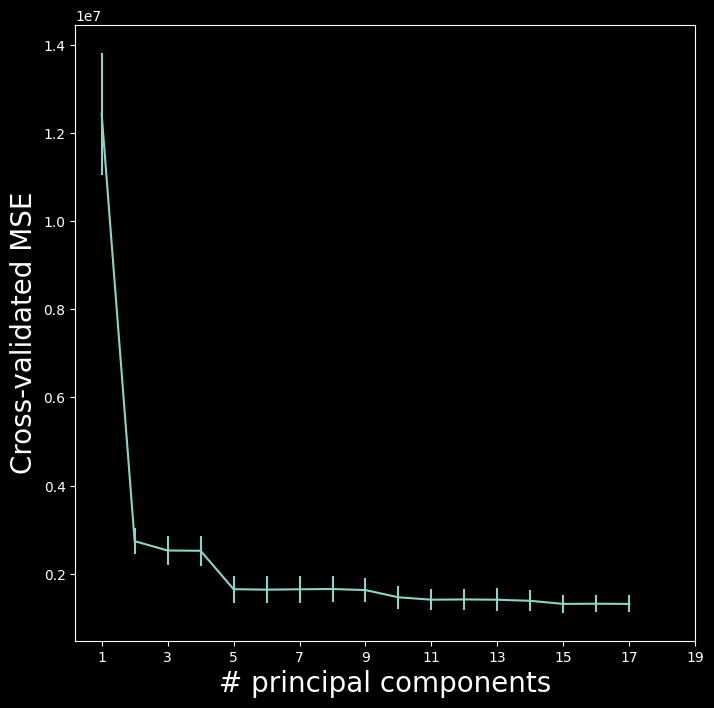

In [8]:
fig, ax = subplots(figsize=(8, 8))

n_comp = param_grid['pca__n_components']
ax.errorbar(n_comp,-grid.cv_results_['mean_test_score'],
grid.cv_results_['std_test_score'] / np.sqrt(K))
ax.set_ylabel('Cross-validated MSE', fontsize=20)
ax.set_xlabel('# principal components', fontsize=20)
ax.set_xticks(n_comp[::2]);

In [9]:
y_predicted = grid.predict(X_test)
test_score = r2_score(y_test, y_predicted)

print(f"best number of principal components: {grid.best_params_['pca__n_components']}")
print(f"R-squired : {test_score:.2f}")
print(f"MSE: {mean_squared_error(y_test, y_predicted):.3}")

best number of principal components: 17
R-squired : 0.92
MSE: 1.43e+06


### (f)     

In [10]:
pls = PLSRegression(n_components=2, scale=True)
pls.fit(X_train, y_train)

K = 5
kfold = skm.KFold(n_splits=K, shuffle=True, random_state=1)
param_grid = {"n_components": range(1, 20)}
grid = skm.GridSearchCV(pls, param_grid, cv=kfold, scoring="neg_mean_squared_error")
warnings.simplefilter("ignore")
grid.fit(X_train, y_train)
warnings.simplefilter("default")

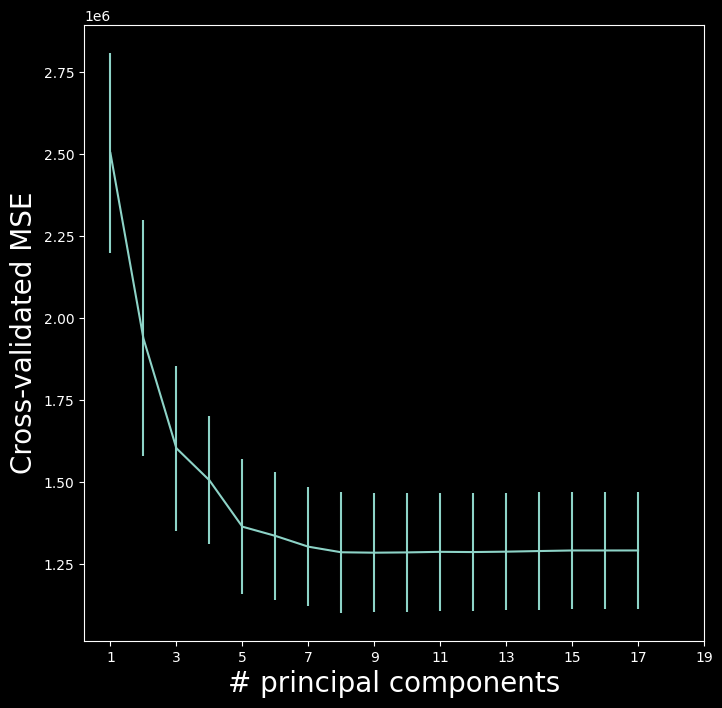

In [11]:
fig, ax = subplots(figsize=(8, 8))

n_comp = param_grid['n_components']
ax.errorbar(n_comp,-grid.cv_results_['mean_test_score'],
grid.cv_results_['std_test_score'] / np.sqrt(K))
ax.set_ylabel('Cross-validated MSE', fontsize=20)
ax.set_xlabel('# principal components', fontsize=20)
ax.set_xticks(n_comp[::2]);

In [12]:
y_predicted = grid.predict(X_test)
test_score = r2_score(y_test, y_predicted)

print(f"best number of principal components: {grid.best_params_['n_components']}")
print(f"R-squired : {test_score:.2f}")
print(f"MSE: {mean_squared_error(y_test, y_predicted):.3}")

best number of principal components: 9
R-squired : 0.92
MSE: 1.43e+06


### (g)

All 5 approches gives approximatelly the same results. R-squired 0.92 and MSE near 1.43e+06